In [1]:
from data import distance_matrix
from lab2 import *
import random
from charles import Population, Individual
from operator import itemgetter
from copy import deepcopy
import networkx as nx
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import distance_matrix as dm
import pandas as pd

In [48]:
def getDistance(node1, node2):
    return np.sqrt((node2[0] - node1[0]) ** 2 + (node2[1] - node1[1]) ** 2)


def getPair(distances, path, nodes_to_remove=[], maximize=True):
    distance_pairs = [(d, (path[i], path[i + 1])) for i, d in enumerate(distances)]
    pairs_to_remove = []
    for i, (d, (n0, n1)) in enumerate(distance_pairs):
        if (n0 in nodes_to_remove) or (n1 in nodes_to_remove):
            pairs_to_remove.append(distance_pairs[i])
    for p in pairs_to_remove:
        distance_pairs.remove(p)
    if maximize == True:
        n_longest = distance_pairs.index(max(distance_pairs, key=lambda x: x[0]))
    if maximize == False:
        n_longest = distance_pairs.index(min(distance_pairs, key=lambda x: x[0]))
    return distance_pairs[n_longest][1]


def getMaxValueKey(d):
    v = list(d.values())
    k = list(d.keys())
    return k[v.index(max(v))]


def getWorstNode(distances, path, nodes_to_remove=[], maximize=True):
    distance_pairs = [(d, (path[i], path[i + 1])) for i, d in enumerate(distances)]
    pairs_to_remove = []
    for i, (d, (n0, n1)) in enumerate(distance_pairs):
        if (n0 in nodes_to_remove) or (n1 in nodes_to_remove):
            pairs_to_remove.append(distance_pairs[i])
    for p in pairs_to_remove:
        distance_pairs.remove(p)
    node_distances = {}
    for i, node in enumerate(path[:-1]):
        if i == 0:
            node_distances[node] = distances[0] + distances[-1]
        else:
            node_distances[node] = distances[i - 1] + distances[i]
    for node in nodes_to_remove:
        node_distances.pop(node, None)
    return getMaxValueKey(node_distances)


def checkNodeLinked(network, node):
    if len(network[node]) > 1:
        return True
    else:
        return False


def linkNode(network, node, closest_node, nodes_to_remove):
    tmp_node = [i for i in network[node]]
    if checkNodeLinked(network, node):
        nodes_to_remove.append(node)
    if checkNodeLinked(network, closest_node):
        tmp_node2 = [i for i in network[closest_node]]
        network[network[closest_node][-1]] += tmp_node
        network[tmp_node[-1]] += tmp_node2
        nodes_to_remove.append(closest_node)
    else:
        network[network[node][-1]] += network[closest_node]
        network[network[closest_node][-1]] += tmp_node
    return network, nodes_to_remove


def getClosestNode(search_space, node, available_nodes):
    closest_node, _ = min(
        [(i, d) for i, d in enumerate(search_space[node]) if i in available_nodes],
        key=lambda x: x[1],
    )
    return closest_node


def getAvailableNodes(search_space, network, node, nodes_to_remove):
    nodes_to_remove = list(set(nodes_to_remove))
    nodes = list(range(len(search_space)))
    total_nodes_to_remove = nodes_to_remove + [network[node][0], network[node][-1]]
    for n in total_nodes_to_remove:
        if n in nodes:
            nodes.remove(n)
    return nodes


def cleanNetwork(network, nodes_to_remove):
    nodes_to_remove = list(set(nodes_to_remove))
    for node in nodes_to_remove:
        if node in network.keys():
            del network[node]
    return network, nodes_to_remove


def initNode(search_space, network, node_init, nodes_to_remove):
    if node_init in network.keys():
        return network[node_init]
    else:
        for node_key, linked_nodes in network.items():
            if node_init in linked_nodes:
                idx = linked_nodes.index(node_init)
                closest_node = getClosestNode(
                    search_space,
                    node_init,
                    [linked_nodes[idx - 1], linked_nodes[idx + 1]],
                )
                if linked_nodes[idx + 1] == closest_node:
                    return network[node_key]


def findPath(search_space, network, node_init, nodes_to_remove):
    path = [i for i in initNode(search_space, network, node_init, nodes_to_remove)]
    available_nodes = getAvailableNodes(search_space, network, path[0], nodes_to_remove)
    node = path[-1]
    while len(available_nodes) > 0:
        node = getClosestNode(search_space, node, available_nodes)
        path += network[node]
        for n in network[node]:
            if n in available_nodes:
                available_nodes.remove(n)
    path.append(path[0])
    return path


def findDistancePath(search_space, path):
    distance = []
    for i, node in enumerate(path[:-1]):
        distance.append(search_space[node][path[i + 1]])
    return distance

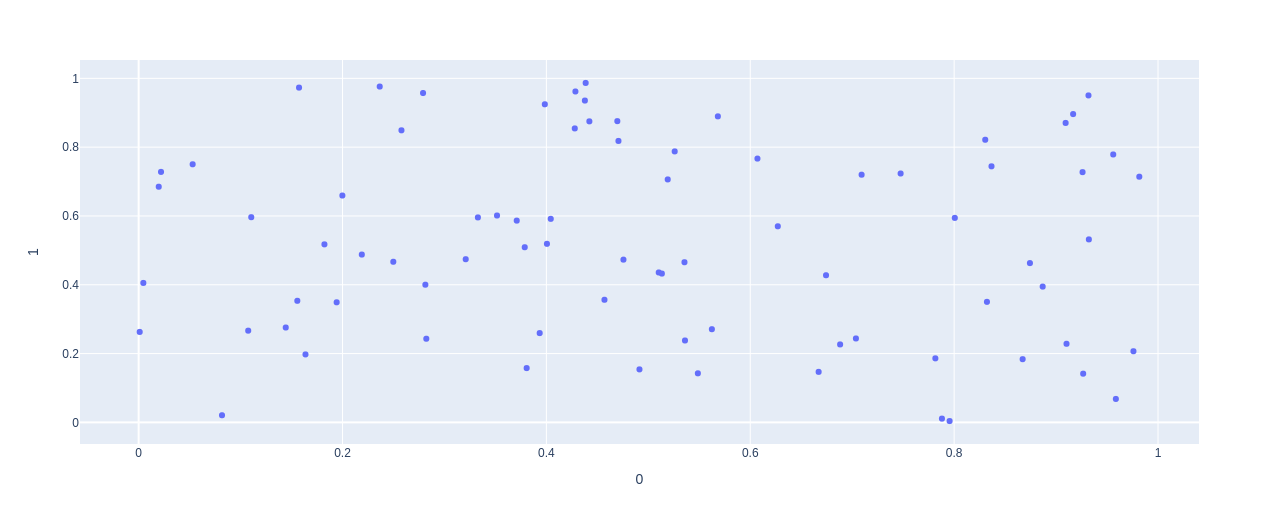

In [67]:
G = nx.random_geometric_graph(80, 0.5)

nodes_, nodes_x, nodes_y = [],[],[]
for k, v in dict(G.nodes.data()).items():
    nodes_.append(v["pos"])
    nodes_x.append(v["pos"][0])
    nodes_y.append(v["pos"][1])

distance_matrix1 = dm(nodes_, nodes_).tolist()
px.scatter(pd.DataFrame(nodes_), x=0, y=1, width=500, height=500)

node_init = 9

[31, 36, 63, 64, 9, 61, 4, 52, 10, 46, 49, 75, 21, 71, 18, 13, 1, 30, 22, 37, 0, 72, 67, 20, 14, 58, 24, 70, 42, 44, 41, 65, 68, 74, 77, 57, 34, 32, 73, 29, 48, 66, 19, 28, 60, 25, 40, 8, 39, 12, 59, 51, 27, 23, 17, 69, 5, 50, 79, 43, 54, 35, 15, 26, 7, 53, 56, 2, 47, 55, 76, 3, 16, 78, 38, 11, 62, 6, 33, 45, 31] 8.330242536442716


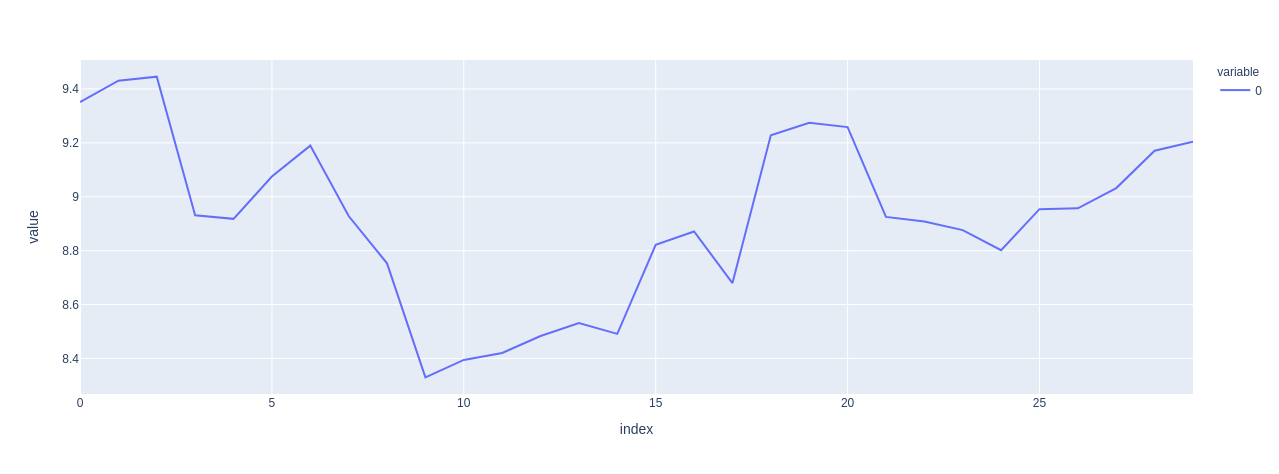

In [90]:
# original where we get the pair of nodes that has the highest distance between them
matrix = distance_matrix1
total_distance = 0
best_path = []
distance_path = []
full_nodes = list(range(len(matrix)))
nodes_to_remove = []
node_network = {i: [i] for i in full_nodes}

node_init = random.randint(0, len(full_nodes)-1)

# d_list = []
# for node in range(len(full_nodes)):
#     path = findPath(matrix, node_network, node, nodes_to_remove)
#     d = sum(findDistancePath(matrix, path))
#     d_list.append(d)
    
# node_init = d_list.index(min(d_list))
node = node_init
path_history = []
remove_history = []
distances_history = []
min_max = True
print(f"{node_init = }\n")
path = findPath(matrix, node_network, node_init, nodes_to_remove)
distances = findDistancePath(matrix, path)
best_distance = sum(distances)
while True:
    network_len_before = len(node_network)
    path = findPath(matrix, node_network, node_init, nodes_to_remove)
    path_history.append(path)
    remove_history.append(nodes_to_remove)
    distances = findDistancePath(matrix, path)
    
    if sum(distances) < best_distance:
        best_distance = sum(distances)
        best_path = path
    if min_max:
        min_max = False
    else:
        min_max = True
    longest_pair = getPair(distances, path, nodes_to_remove, maximize=True)
#     print(f"{path = }")
#     print(f"{nodes_to_remove = }")
#     print(f"{longest_pair = }")
    for node in longest_pair:
        for i in range(3):
            if (node in nodes_to_remove) or (len(node_network) <= 2):
#                 print(f"break at {i}")
                break
#             print(f"{node = } ~ {i = }")
            available_nodes = getAvailableNodes(
                matrix, node_network, node, nodes_to_remove
            )
#             print(f"{len(available_nodes) = } | {available_nodes}")
#             print(f"{nodes_to_remove = }")
#             print(f"{node_network = }")
            closest_node = getClosestNode(matrix, node, available_nodes)
#             print(f"Linking: {node} => {closest_node}")
            node_network, nodes_to_remove = linkNode(
                node_network, node, closest_node, nodes_to_remove
            )
            node_network, nodes_to_remove = cleanNetwork(node_network, nodes_to_remove)

#             print()
#         print()
#     print(f"{sum(distances) = }")
    distances_history.append(sum(distances))
    if len(node_network) == 2:
        path = findPath(matrix, node_network, node_init, nodes_to_remove)
        distances = findDistancePath(matrix, path)
        path_history.append(path)
        remove_history.append(nodes_to_remove)
#         print(f"\n{len(node_network) = }")
#         print(f"\n{nodes_to_remove = }")
#         print(f"\n{path = }")
#         print(f"{distances = }")
#         print(f"{sum(distances) = }")
        break
        
print(best_path, sum(findDistancePath(matrix, best_path)))
px.line(pd.DataFrame(distances_history))


node_init = 9

[31, 36, 63, 64, 9, 61, 4, 52, 10, 46, 49, 75, 21, 71, 18, 13, 1, 30, 22, 37, 0, 24, 70, 58, 42, 72, 67, 20, 14, 44, 16, 76, 3, 41, 68, 65, 57, 34, 32, 77, 74, 73, 29, 48, 66, 19, 28, 60, 25, 40, 8, 39, 12, 59, 51, 27, 23, 69, 11, 38, 45, 62, 6, 33, 78, 55, 47, 2, 53, 56, 7, 43, 54, 79, 35, 15, 26, 50, 5, 17, 31] 8.51872745019369


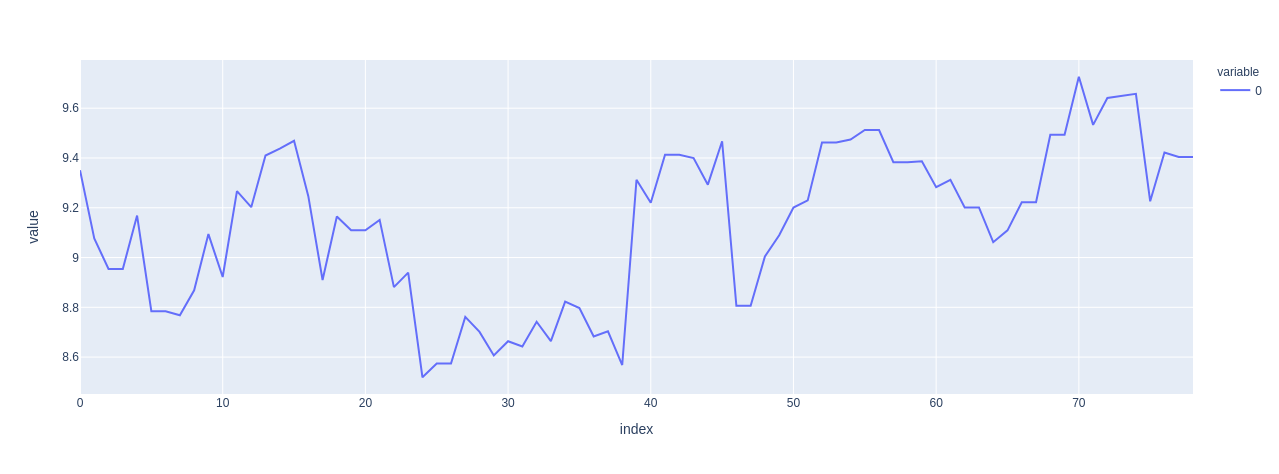

In [91]:
# get the worst node with the highest sum of distances to its connected nodes
matrix = distance_matrix1
total_distance = 0
best_path = []
distance_path = []
full_nodes = list(range(len(matrix)))
nodes_to_remove = []
node_network = {i: [i] for i in full_nodes}

# node_init = random.randint(0, len(full_nodes)-1)

# d_list = []
# for node in range(len(full_nodes)):
#     path = findPath(matrix, node_network, node, nodes_to_remove)
#     d = sum(findDistancePath(matrix, path))
#     d_list.append(d)
    
# node_init = d_list.index(min(d_list))
node = node_init
path_history = []
remove_history = []
distances_history = []
min_max = True
print(f"{node_init = }\n")
path = findPath(matrix, node_network, node_init, nodes_to_remove)
distances = findDistancePath(matrix, path)
best_distance = sum(distances)
while True:
    network_len_before = len(node_network)
    path = findPath(matrix, node_network, node_init, nodes_to_remove)
    path_history.append(path)
    remove_history.append(nodes_to_remove)
    distances = findDistancePath(matrix, path)
    
    if sum(distances) < best_distance:
        best_distance = sum(distances)
        best_path = path
    if min_max:
        min_max = False
    else:
        min_max = True
    worst_node = getWorstNode(distances, path, nodes_to_remove, maximize=True)
#     print(f"{path = }")
#     print(f"{nodes_to_remove = }")
#     print(f"{worst_node = }")
    for node in [worst_node]:
        for i in range(1):
            if (node in nodes_to_remove) or (len(node_network) <= 2):
#                 print(f"break at {i}")
                break
#             print(f"{node = } ~ {i = }")
            available_nodes = getAvailableNodes(
                matrix, node_network, node, nodes_to_remove
            )
#             print(f"{len(available_nodes) = } | {available_nodes}")
#             print(f"{nodes_to_remove = }")
#             print(f"{node_network = }")
            closest_node = getClosestNode(matrix, node, available_nodes)
#             print(f"Linking: {node} => {closest_node}")
            node_network, nodes_to_remove = linkNode(
                node_network, node, closest_node, nodes_to_remove
            )
            node_network, nodes_to_remove = cleanNetwork(node_network, nodes_to_remove)

#             print()
#         print()
#     print(f"{sum(distances) = }")
    distances_history.append(sum(distances))
    if len(node_network) == 2:
        path = findPath(matrix, node_network, node_init, nodes_to_remove)
        distances = findDistancePath(matrix, path)
        path_history.append(path)
        remove_history.append(nodes_to_remove)
#         print(f"\n{len(node_network) = }")
#         print(f"\n{nodes_to_remove = }")
#         print(f"\n{path = }")
#         print(f"{distances = }")
#         print(f"{sum(distances) = }")
        break
        
print(best_path, sum(findDistancePath(matrix, best_path)))
px.line(pd.DataFrame(distances_history))


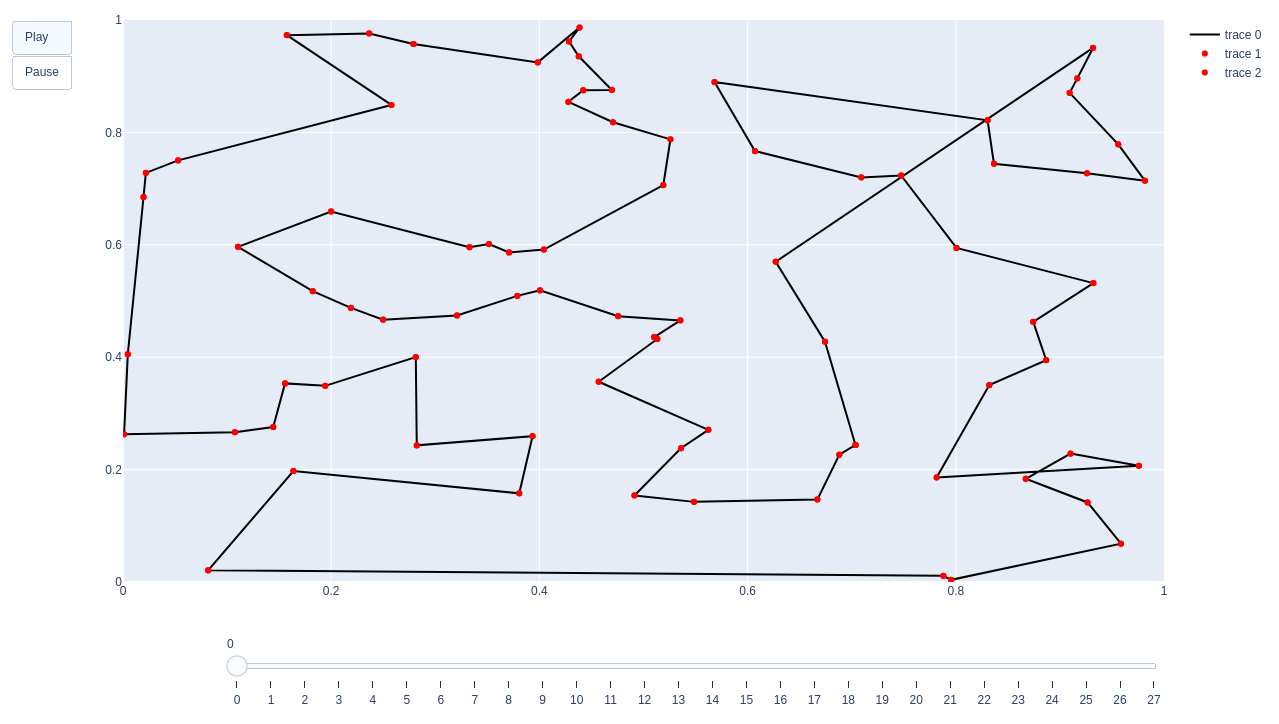

In [74]:
paths = []
for path in path_history:
    path_nodes_x = [nodes_x[node] for node in path]
    path_nodes_y = [nodes_y[node] for node in path]
    paths.append([path_nodes_x, path_nodes_y])

removals = []
for nodes_rm in remove_history:
    if len(nodes_rm) == 0:
        removals.append([[], []])
    else:
        removals_x = [nodes_x[node] for node in nodes_rm]
        removals_y = [nodes_y[node] for node in nodes_rm]
        removals.append([removals_x, removals_y])

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "transition": {"duration": 0, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": [{
        "args": [
            [i],
            {
                "frame": {"duration": 0, "redraw": False},
                "mode": "immediate",
                "transition": {"duration": 0},
            },
        ],
        "label": i,
        "method": "animate",
    } for i in range(len(paths))],
}

fig = go.Figure(
    data=[
        go.Scatter(
            x=paths[0][0], y=paths[0][1], mode="lines", marker=dict(color="Black")
        ),
        go.Scatter(
            x=paths[0][0], y=paths[0][1], mode="markers", marker=dict(color="Red")
        ),
        go.Scatter(
            x=paths[0][0], y=paths[0][1], mode="markers", hovertext=path_history[0], marker=dict(color="Red")
        ),
    ],
    layout=go.Layout(
        xaxis=dict(range=[0, 1], autorange=False),
        yaxis=dict(range=[0, 1], autorange=False),
        width=700,
        height=700,
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[
                            None,
                            {
                                "frame": {"duration": 1000, "redraw": False},
                                "fromcurrent": True,
                                "transition": {
                                    "duration": 0,
                                    "easing": "quadratic-in-out",
                                },
                            },
                        ],
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0},
                            },
                        ],
                    ),
                ],
            )
        ],
        sliders=[sliders_dict]
    ),
    frames=[
        go.Frame(
            data=[
                go.Scatter(x=p[0], y=p[1]),
                go.Scatter(
                    x=paths[0][0],
                    y=paths[0][1],
                    mode="markers",
                    marker=dict(color="Red"),
                ),
                go.Scatter(x=removals[i][0], y=removals[i][1], marker=dict(size=10, color="Blue")),
            ],
            name=str(i)
        )
        for i, p in enumerate(paths)
    ],
)
fig.update_layout(dict(margin=dict(l=20, r=20, t=20, b=20)))
fig.write_html("animation.html")
fig.show()